# Reading DeepFashion2 into CSV

In [1]:
import os
import json
import pandas as pd
from tqdm import tqdm
from typing import List, Optional
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
from IPython.display import FileLink
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import shutil
import skimage
from PIL import Image, ImageDraw

tqdm.pandas()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
ROOT_DIR = "/kaggle/working/"

In [3]:
def json_to_df(dir_path):
    image_folder = os.path.join(dir_path, 'image')
    annotation_folder = os.path.join(dir_path, 'annos')
    annotations = []
    
    for json_file in tqdm(os.listdir(annotation_folder), colour="GREEN"):
        with open(os.path.join(annotation_folder, json_file), 'r') as f:
            annotation_data = json.load(f)
            image_filename = json_file.split('.')[0] + '.jpg'
            image_path = os.path.join(image_folder, image_filename)
            height, width, _ = cv2.imread(image_path).shape
            for instance_name, instance_data in annotation_data.items():
                if "item" in instance_name:
                    annotations.append({
                        'path': image_path,
                        'segmentation': instance_data['segmentation'],
                        'landmarks': instance_data['landmarks'],
                        'b_box': instance_data['bounding_box'],
                        'category_id': instance_data['category_id'],
                        'category_name': instance_data['category_name'],
                        'scale': instance_data['scale'],
                        'viewpoint': instance_data['viewpoint'],
                        'occlusion': instance_data['occlusion'],
                        'zoom_in': instance_data['zoom_in'],
                        'img_height': height,
                        'img_width': width
                    })
    json_df = pd.DataFrame(annotations)
    return json_df

In [ ]:
train_df = json_to_df("/kaggle/input/deepfashion2-compressed-original/train")
validation_df = json_to_df("/kaggle/input/deepfashion2-compressed-original/validation")

In [ ]:
# Test dataframe will only have one column with all the file paths & (optionally) image dimensions
TEST_DIRECTORY = "/kaggle/input/deepfashion2-compressed-original/test/test/image"
test_paths = []
for image in tqdm(os.listdir(TEST_DIRECTORY), colour="GREEN"):
    test_paths.append(os.path.join(TEST_DIRECTORY, image))

# Saving & Reloading the created Dataframes
Saving the dataframes as .csv files inorder to avoid recalculation. Code block can be omitted if the entire notebook is run from the first code cell

In [ ]:
TARGET_DIR = ROOT_DIR + "input/"
os.makedirs(TARGET_DIR)

train_df.to_csv(TARGET_DIR + "train.csv", index=False)
validation_df.to_csv(TARGET_DIR + "validation.csv", index=False)
# test_df.to_csv(TARGET_DIR + "test.csv", index=False)

In [ ]:
# Kaggle kernels have a tendency to crash when downloading large files
!zip -r training_data.zip /kaggle/working/input
FileLink(r'training_data.zip')

In [4]:
train_df = pd.read_csv('/kaggle/input/deepfashion2-dataframes/train.csv')
validation_df = pd.read_csv('/kaggle/input/deepfashion2-dataframes/validation.csv')
# test_df = pd.read_csv('/kaggle/input/deepfashion2-dataframes/test.csv')

# EDA on DeepFashion2

In [5]:
validation_df['segmentation'] = validation_df['segmentation'].progress_apply(lambda x: json.loads(x.replace("'", "\"")))
train_df['segmentation'] = train_df['segmentation'].progress_apply(lambda x: json.loads(x.replace("'", "\"")))

100%|██████████| 312186/312186 [00:09<00:00, 31936.56it/s]


In [6]:
validation_df['b_box'] = validation_df['b_box'].progress_apply(lambda x: json.loads(x.replace("'", "\"")))
train_df['b_box'] = train_df['b_box'].progress_apply(lambda x: json.loads(x.replace("'", "\"")))

100%|██████████| 312186/312186 [00:02<00:00, 118887.58it/s]


In [7]:
validation_df['landmarks'] = validation_df['landmarks'].progress_apply(lambda x: json.loads(x.replace("'", "\"")))
train_df['landmarks'] = train_df['landmarks'].progress_apply(lambda x: json.loads(x.replace("'", "\"")))

100%|██████████| 312186/312186 [00:06<00:00, 50368.32it/s]


In [8]:
print(train_df.dtypes)
print("\n\n")
print(validation_df.dtypes)

path             object
segmentation     object
landmarks        object
b_box            object
category_id       int64
category_name    object
scale             int64
viewpoint         int64
occlusion         int64
zoom_in           int64
img_height        int64
img_width         int64
dtype: object



path             object
segmentation     object
landmarks        object
b_box            object
category_id       int64
category_name    object
scale             int64
viewpoint         int64
occlusion         int64
zoom_in           int64
img_height        int64
img_width         int64
dtype: object


In [9]:
display(train_df)

print("\n\n\n")

display(validation_df)

path  \
0       /kaggle/input/deepfashion2-compressed-original...   
1       /kaggle/input/deepfashion2-compressed-original...   
2       /kaggle/input/deepfashion2-compressed-original...   
3       /kaggle/input/deepfashion2-compressed-original...   
4       /kaggle/input/deepfashion2-compressed-original...   
...                                                   ...   
312181  /kaggle/input/deepfashion2-compressed-original...   
312182  /kaggle/input/deepfashion2-compressed-original...   
312183  /kaggle/input/deepfashion2-compressed-original...   
312184  /kaggle/input/deepfashion2-compressed-original...   
312185  /kaggle/input/deepfashion2-compressed-original...   

                                             segmentation  \
0       [[360, 172, 364, 166, 371, 163, 325, 168, 299,...   
1       [[381, 306, 334, 289, 297, 266, 261, 350, 225,...   
2       [[320, 33, 309, 86, 247, 102, 183, 78, 172, 27...   
3       [[150, 285, 249, 302, 350, 270, 464, 396, 464,...   
4       [[351, 246, 353, 277, 325, 297, 279, 302, 242,...   
...                                                   ...   
312181  [[471, 456, 436, 503, 386, 553, 338, 519, 314,...   
312182  [[528, 863, 410, 868, 299, 861, 296, 1003, 320...   
312183  [[214.0, 269.0, 226.0, 297.0, 248.0, 357.0, 25...   
312184  [[212.94, 211.43, 219.97, 202.76, 235.84, 192....   
312185  [[711, 98, 500, 66, 327, 63, 300, 222, 283, 35...   

                                                landmarks  \
0       [387, 176, 1, 371, 163, 1, 364, 166, 1, 360, 1...   
1       [297, 266, 1, 334, 289, 1, 381, 306, 1, 261, 3...   
2       [241, 45, 2, 172, 27, 2, 183, 78, 2, 247, 102,...   
3       [150, 285, 2, 249, 302, 2, 350, 270, 2, 0, 0, ...   
4       [298, 270, 1, 242, 287, 2, 279, 302, 2, 325, 2...   
...                                                   ...   
312181  [388, 456, 1, 314, 458, 1, 338, 519, 1, 386, 5...   
312182  [299, 861, 1, 410, 868, 1, 528, 863, 1, 296, 1...   
312183  [304, 301, 1, 256, 320, 2, 281, 318, 2, 308, 3...   
312184  [274, 194, 1, 234, 202, 2, 254, 237, 2, 290, 2...   
312185  [327, 63, 1, 500, 66, 1, 711, 98, 1, 300, 222,...   

                        b_box  category_id        category_name  scale  \
0        [227, 155, 442, 381]            4  long sleeve outwear      2   
1        [209, 263, 387, 539]            8             trousers      2   
2           [6, 17, 460, 341]            1     short sleeve top      3   
3          [0, 263, 465, 630]            9                skirt      3   
4        [178, 182, 695, 800]           10   short sleeve dress      3   
...                       ...          ...                  ...    ...   
312181  [112, 448, 711, 1039]            2      long sleeve top      2   
312182  [286, 855, 542, 1140]            8             trousers      1   
312183   [191, 168, 495, 783]           13          sling dress      2   
312184   [155, 164, 452, 440]            1     short sleeve top      2   
312185    [259, 52, 725, 488]            7               shorts      2   

        viewpoint  occlusion  zoom_in  img_height  img_width  
0               2          2        1         640        640  
1               2          2        1         640        640  
2               1          1        1         631        468  
3               1          1        3         631        468  
4               2          2        1         926        750  
...           ...        ...      ...         ...        ...  
312181          2          2        1        1141        800  
312182          2          2        3        1141        800  
312183          2          1        1         960        640  
312184          2          2        1         960        640  
312185          3          2        1         660        880  

[312186 rows x 12 columns]

path  \
0      /kaggle/input/deepfashion2-compressed-original...   
1      /kaggle/input/deepfashion2-compressed-original...   
2      /kaggle/input/deepfashion2-compressed-original...   
3      /kaggle/input/deepfashion2-compressed-original...   
4      /kaggle/input/deepfashion2-compressed-original...   
...                                                  ...   
52485  /kaggle/input/deepfashion2-compressed-original...   
52486  /kaggle/input/deepfashion2-compressed-original...   
52487  /kaggle/input/deepfashion2-compressed-original...   
52488  /kaggle/input/deepfashion2-compressed-original...   
52489  /kaggle/input/deepfashion2-compressed-original...   

                                            segmentation  \
0      [[122.15094339622641, 5.886792452830188, 123.6...   
1      [[153.70105263157896, 88.67368421052632, 164.2...   
2      [[307.4285714285714, 597.1770451770451, 354.53...   
3      [[335.16483516483515, 57.16239316239315, 345.3...   
4      [[248.34904264710372, 632.7944963623632, 253.0...   
...                                                  ...   
52485  [[155.65306122448987, 584.0596546310832, 158.2...   
52486  [[159.6247146792601, 460.1382133018498, 164.39...   
52487  [[22.895972714155036, 112.48107044470696, 12.6...   
52488  [[162.26349206346143, 614.9777777777668, 192.4...   
52489  [[144.5900039354486, 313.05354847172816, 151.9...   

                                               landmarks  \
0      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1      [154, 91, 1, 274, 100, 1, 406, 127, 1, 79, 270...   
2      [305, 597, 1, 444, 601, 1, 626, 589, 1, 288, 7...   
3      [430, 46, 1, 336, 63, 2, 378, 82, 1, 443, 88, ...   
4      [251, 629, 1, 358, 618, 1, 449, 591, 1, 255, 7...   
...                                                  ...   
52485  [334, 291, 1, 277, 289, 2, 306, 304, 2, 340, 3...   
52486  [165, 454, 1, 284, 452, 1, 411, 449, 1, 173, 5...   
52487  [259, 15, 1, 151, 12, 2, 200, 80, 2, 279, 113,...   
52488  [162, 615, 1, 230, 609, 1, 289, 607, 1, 156, 6...   
52489  [200, 316, 1, 143, 316, 1, 205, 348, 2, 234, 4...   

                      b_box  category_id    category_name  scale  viewpoint  \
0         [32, 2, 467, 357]            2  long sleeve top      3          2   
1         [1, 79, 467, 587]            9            skirt      3          2   
2      [274, 580, 666, 879]            8         trousers      2          2   
3       [213, 26, 712, 656]            2  long sleeve top      3          2   
4      [236, 583, 543, 892]            8         trousers      2          2   
...                     ...          ...              ...    ...        ...   
52485  [128, 275, 541, 795]            2  long sleeve top      2          2   
52486  [161, 446, 417, 623]            8         trousers      2          2   
52487      [2, 8, 466, 554]            5             vest      3          2   
52488  [147, 601, 295, 701]            8         trousers      1          2   
52489    [0, 299, 386, 684]            2  long sleeve top      3          3   

       occlusion  zoom_in  img_height  img_width  
0              2        2         702        468  
1              2        2         702        468  
2              2        3         880        880  
3              2        1         880        880  
4              2        3         912        750  
...          ...      ...         ...        ...  
52485          1        1         960        640  
52486          2        2         624        468  
52487          1        2         624        468  
52488          2        2         702        468  
52489          2        2         702        468  

[52490 rows x 12 columns]

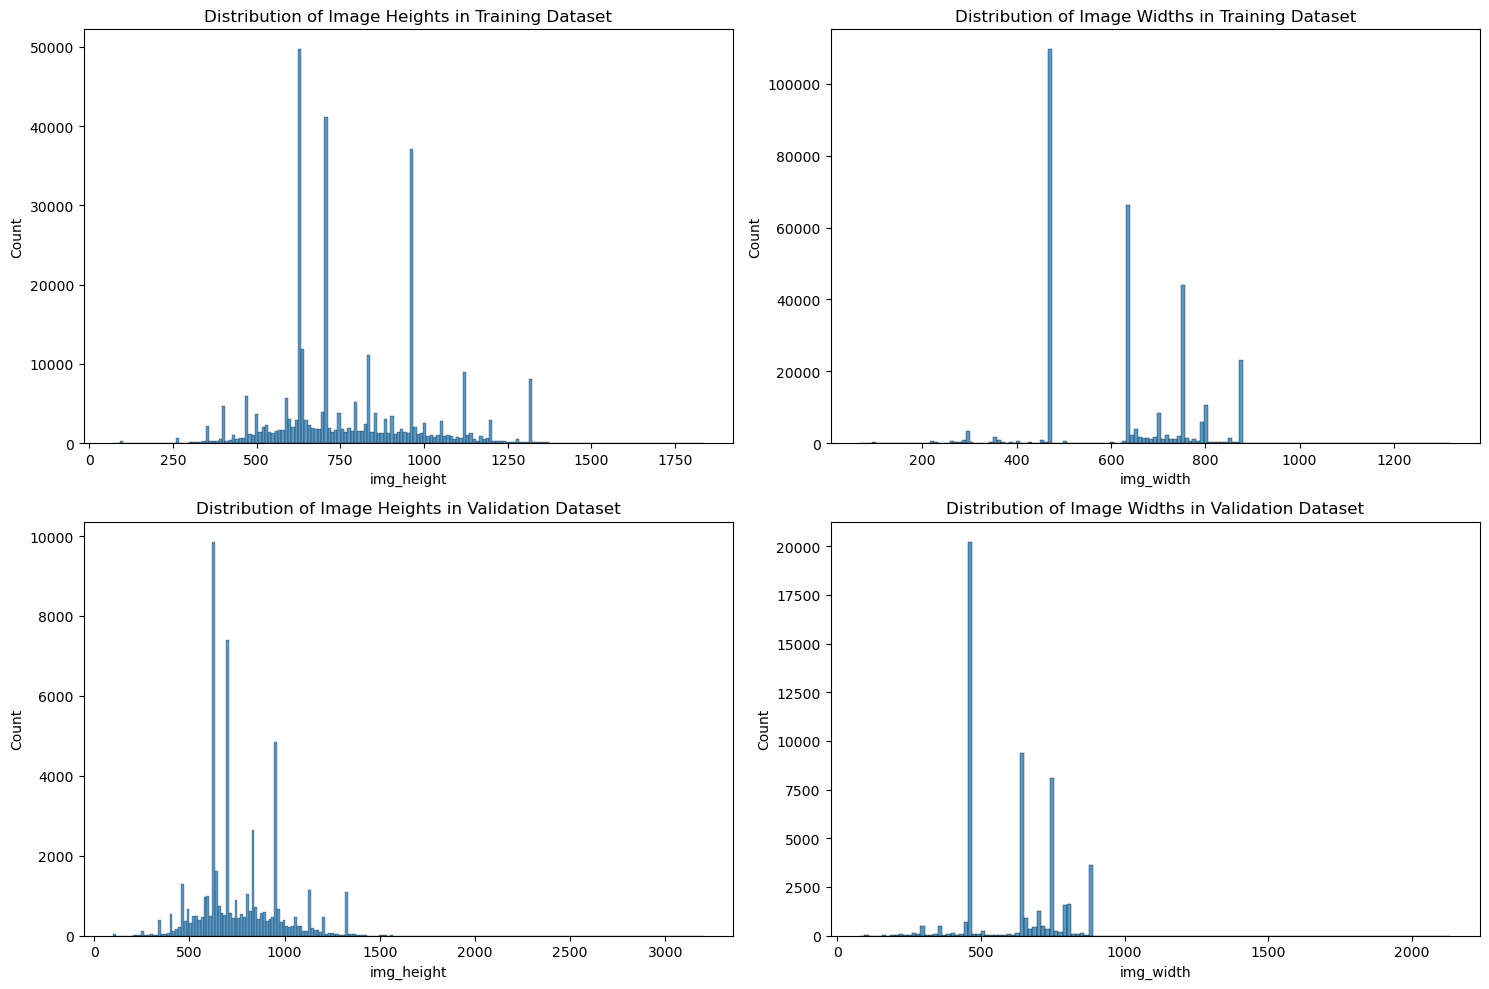

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(15,10))
sns.histplot(train_df['img_height'], ax=ax[0, 0]).set_title('Distribution of Image Heights in Training Dataset')
sns.histplot(train_df['img_width'], ax=ax[0, 1]).set_title('Distribution of Image Widths in Training Dataset')

sns.histplot(validation_df['img_height'], ax=ax[1, 0]).set_title('Distribution of Image Heights in Validation Dataset')
sns.histplot(validation_df['img_width'], ax=ax[1, 1]).set_title('Distribution of Image Widths in Validation Dataset')

plt.tight_layout()
plt.show()

In [11]:
print("Maximum height found in the training dataset is : {}".format(train_df.img_height.max()))
print("Maximum height found in the validation dataset is : {}".format(validation_df.img_height.max()))

print("\nMaximum width found in the training dataset is : {}".format(train_df.img_width.max()))
print("Maximum height found in the validation dataset is : {}".format(validation_df.img_width.max()))

Maximum height found in the training dataset is : 1835
Maximum height found in the validation dataset is : 3201

Maximum width found in the training dataset is : 1320
Maximum height found in the validation dataset is : 2134


# Resizing the images and the annotations

In [12]:
RESIZED_TARGET_DIRECTORY = "/kaggle/working/resized"
TARGET_DIR = ROOT_DIR + "input/"
TARGET_SIZE = (256, 256)
os.makedirs(os.path.join(RESIZED_TARGET_DIRECTORY, "train"))
os.makedirs(os.path.join(RESIZED_TARGET_DIRECTORY, "validation"))
os.makedirs(os.path.join(RESIZED_TARGET_DIRECTORY, "test"))
os.makedirs(TARGET_DIR)

In [13]:
def resize_bbox(bbox, x_scale, y_scale):
    return [bbox[0] * x_scale, 
            bbox[1] * y_scale, 
            bbox[2] * x_scale, 
            bbox[3] * y_scale]

def resize_segmentation(segmentation, x_scale, y_scale):
    resized_segmentation = []
    for polygon in segmentation:
        resized_polygon = []
        for i in range(0, len(polygon), 2):
            x = polygon[i] * x_scale
            y = polygon[i + 1] * y_scale
            resized_polygon.extend([x, y])
        resized_segmentation.append(resized_polygon)
        
    return resized_segmentation

def resize_image_and_annotations(row):
    
    # Creating path for the resized image
    # sample original path -> /kaggle/input/deepfashion2-compressed-original/train/image/000001.jpg   
    img_path = row['path']
    name_list = img_path.split("/")
    df_type = name_list[-3]
    new_img_path = os.path.join(RESIZED_TARGET_DIRECTORY, df_type, name_list[-1]) 
    
    # Reading & resizing the image; saving resized image into new folder
    image = cv2.imread(img_path)
    original_height, original_width = image.shape[:2]
    resized_image = cv2.resize(image, TARGET_SIZE, interpolation=cv2.INTER_AREA)
    cv2.imwrite(new_img_path, resized_image)
    
    if df_type == "test":
        # Update the dataframe row
        row['path'] = new_img_path
    else:  
        bbox = row['b_box']
        segmentation = row['segmentation']
        
        # Calculate the scaling factors
        x_scale = TARGET_SIZE[0] / original_width
        y_scale = TARGET_SIZE[1] / original_height

        # Resize the bounding box
        resized_bbox = resize_bbox(bbox, x_scale, y_scale)

        # Resize the segmentation
        resized_segmentation = resize_segmentation(segmentation, x_scale, y_scale)

        # Update the dataframe row
        row['path'] = new_img_path
        row['b_box'] = resized_bbox
        row['segmentation'] = resized_segmentation
        row['img_height'] = TARGET_SIZE[1]
        row['img_width'] = TARGET_SIZE[0]

    return row

In [ ]:
train_df_resized = train_df.progress_apply(resize_image_and_annotations, axis=1)
validation_df_resized = validation_df.progress_apply(resize_image_and_annotations, axis=1)
# test_df_resized = test_df.progress_apply(resize_image_and_annotations, axis=1)

In [ ]:
train_df_resized.to_csv(TARGET_DIR + "train.csv", index=False)
validation_df_resized.to_csv(TARGET_DIR + "validation.csv", index=False)
# test_df_resized.to_csv(TARGET_DIR + "test.csv", index=False)

In [ ]:
# Kaggle kernels have a tendency to crash when downloading large files; creating a downloadable link for the augmented dataset
!zip -r resized_images.zip /kaggle/working/resized > /dev/null 2>&1
FileLink(r'resized_images.zip')

In [ ]:
# Kaggle kernels have a tendency to crash when downloading large files; creating a downloadable link for the augmented dataset
!zip -r resized_dataframes.zip /kaggle/working/input > /dev/null 2>&1
FileLink(r'resized_dataframes.zip')

# More EDA on Deepfashion2

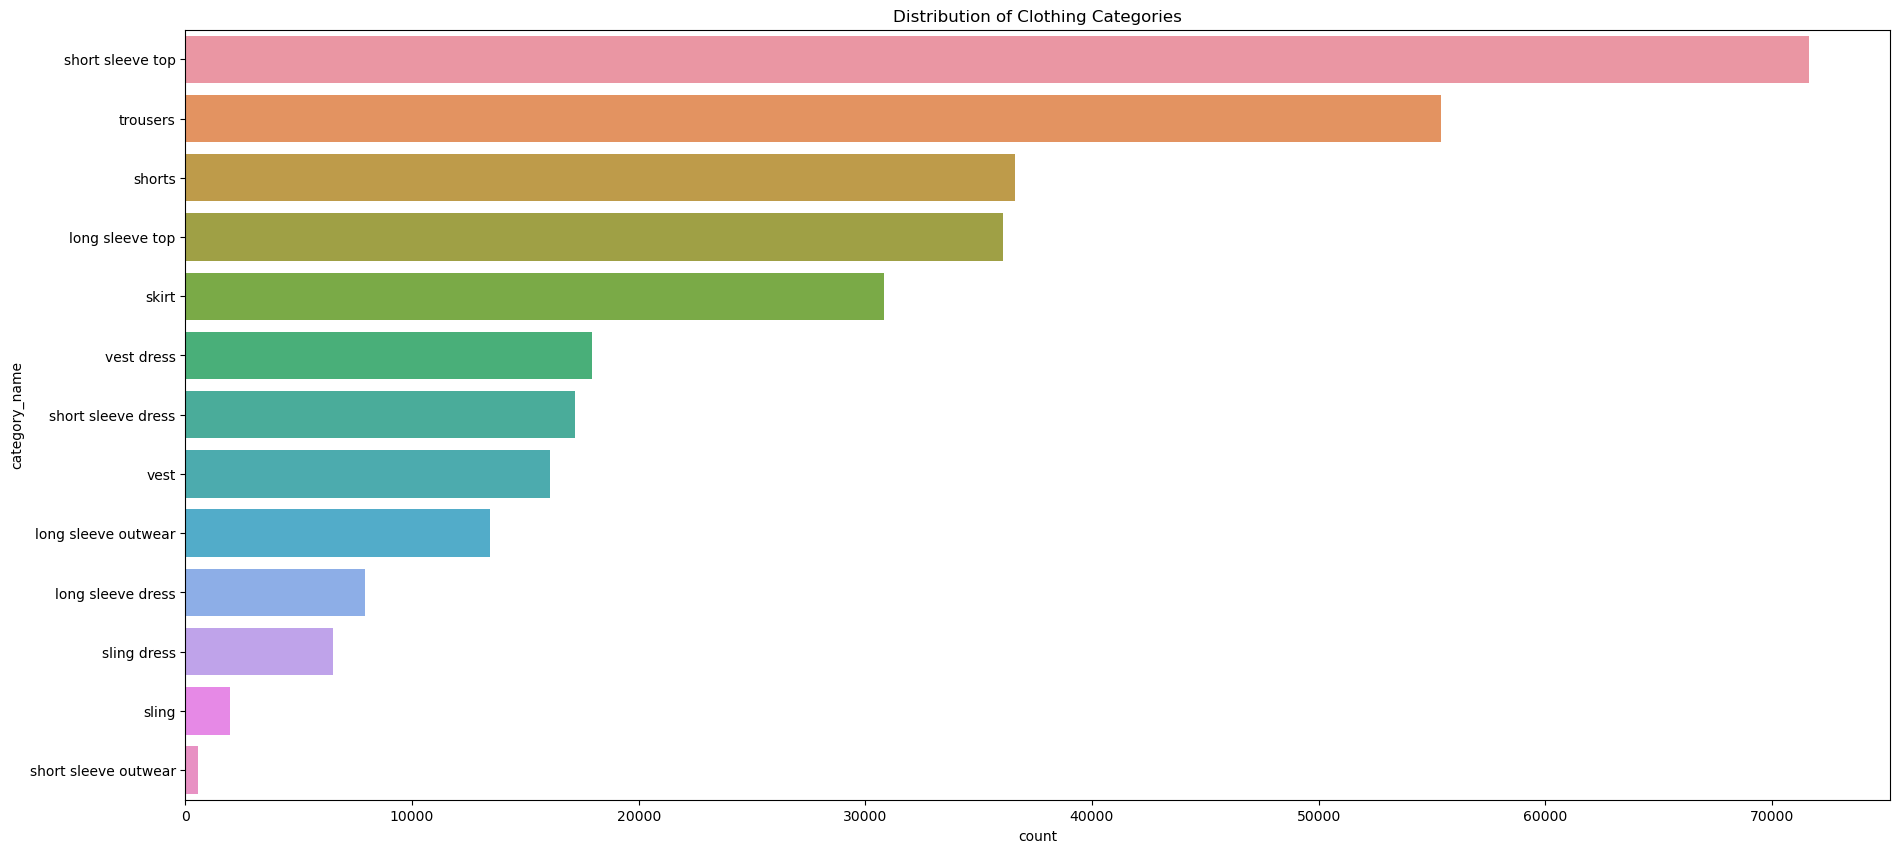

In [16]:
fig, ax = plt.subplots(figsize=(22,10))
sns.countplot(y='category_name', data=train_df_resized, order=train_df_resized['category_name'].value_counts().index)
plt.title('Distribution of Clothing Categories')
plt.show()

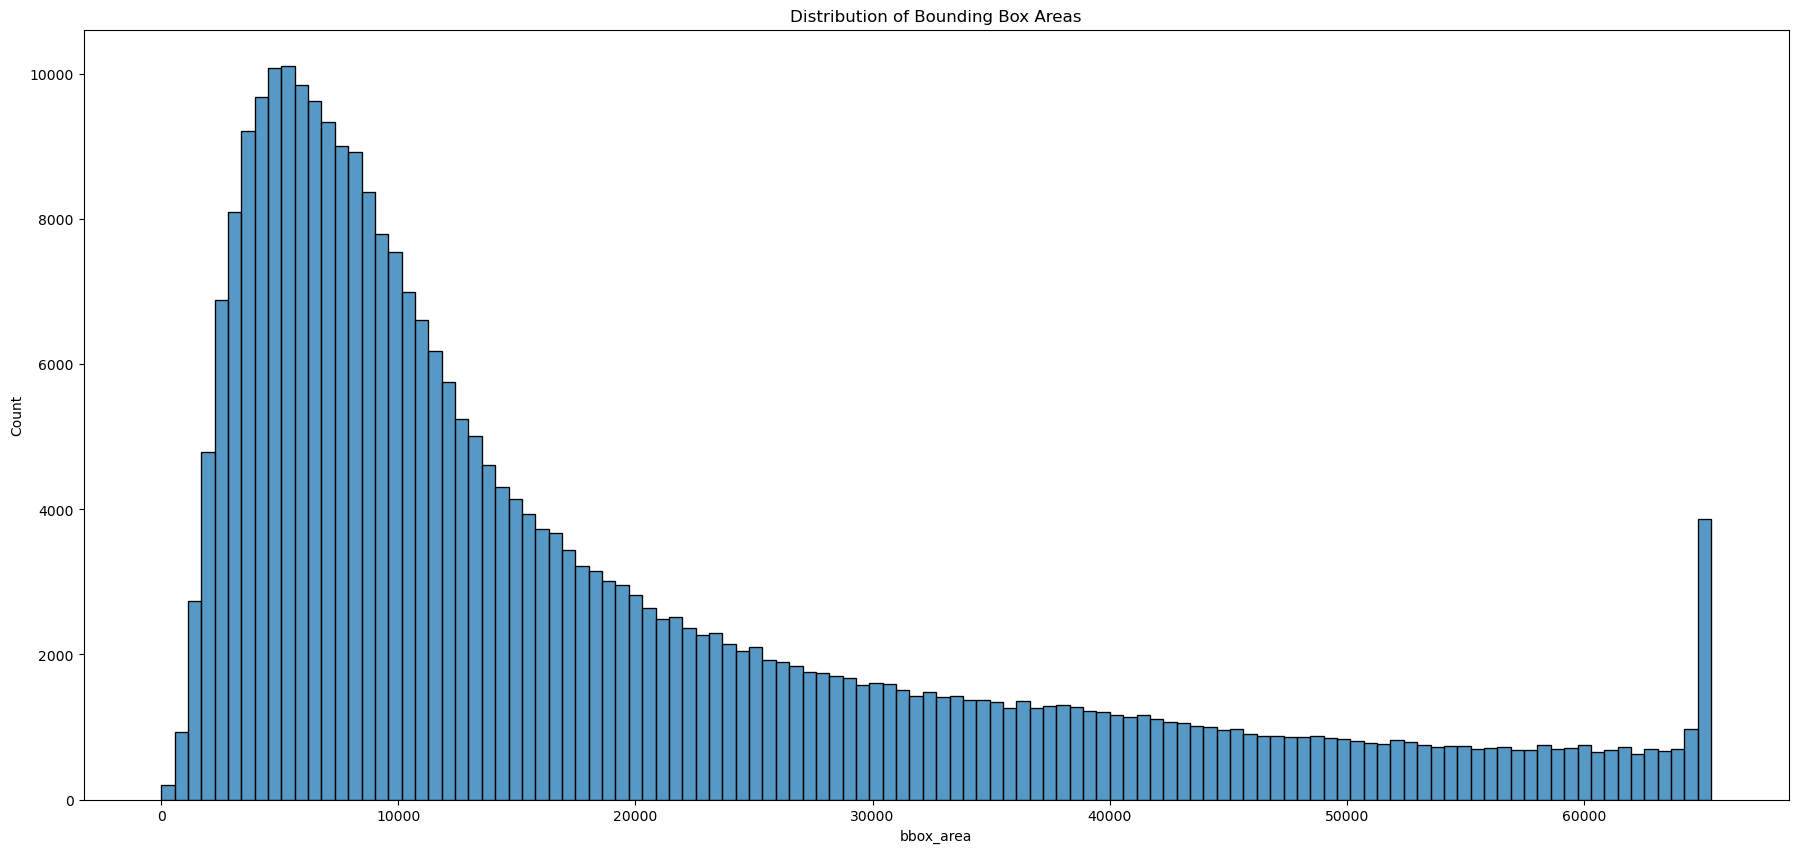

In [17]:
fig, ax = plt.subplots(figsize=(22,10))
train_df_resized['bbox_area'] = (train_df_resized['b_box'].apply(lambda x: x[2]-x[0])) * (train_df_resized['b_box'].apply(lambda x: x[3]-x[1]))
sns.histplot(train_df_resized['bbox_area'])
plt.title('Distribution of Bounding Box Areas')
plt.show()

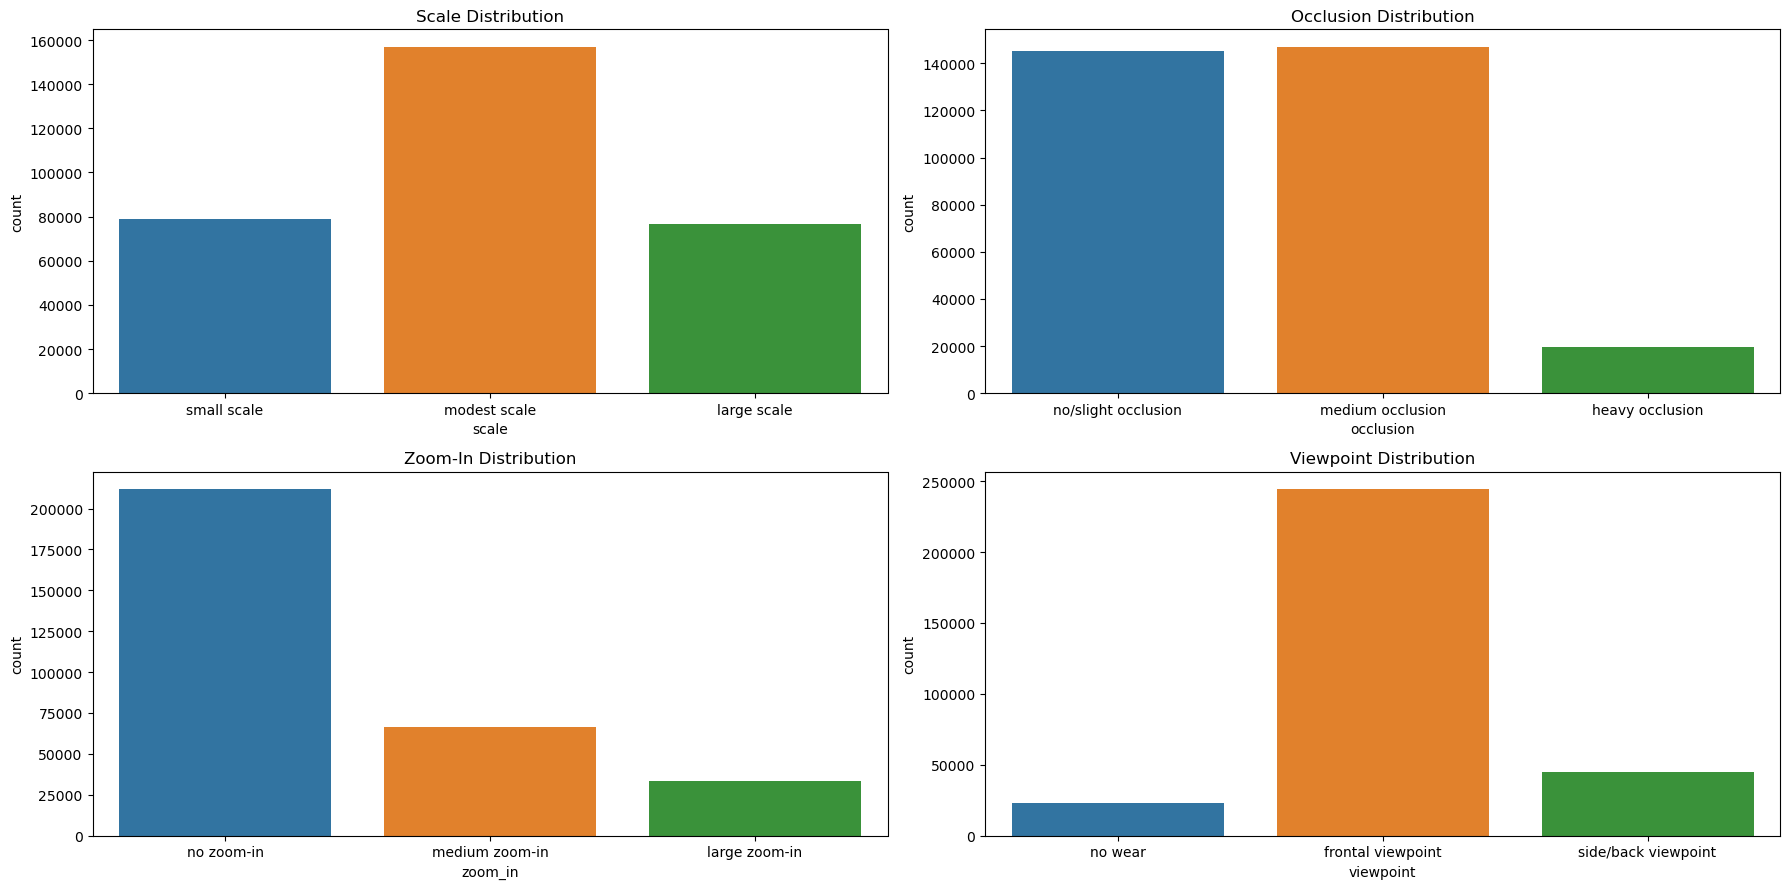

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(18, 9))

sns.countplot(data=train_df_resized, x='scale', ax=axes[0, 0]).set_title('Scale Distribution')
axes[0, 0].set(xticklabels = ('small scale', 'modest scale', 'large scale'))
             
sns.countplot(data=train_df_resized, x='occlusion', ax=axes[0, 1]).set_title('Occlusion Distribution')
axes[0, 1].set(xticklabels = ('no/slight occlusion', 'medium occlusion', 'heavy occlusion'))

sns.countplot(data=train_df_resized, x='zoom_in', ax=axes[1, 0]).set_title('Zoom-In Distribution')
axes[1, 0].set(xticklabels = ('no zoom-in', 'medium zoom-in', 'large zoom-in'))

sns.countplot(data=train_df_resized, x='viewpoint', ax=axes[1, 1]).set_title('Viewpoint Distribution')
axes[1, 1].set(xticklabels = ('no wear', 'frontal viewpoint', 'side/back viewpoint'))

plt.tight_layout()
plt.show()

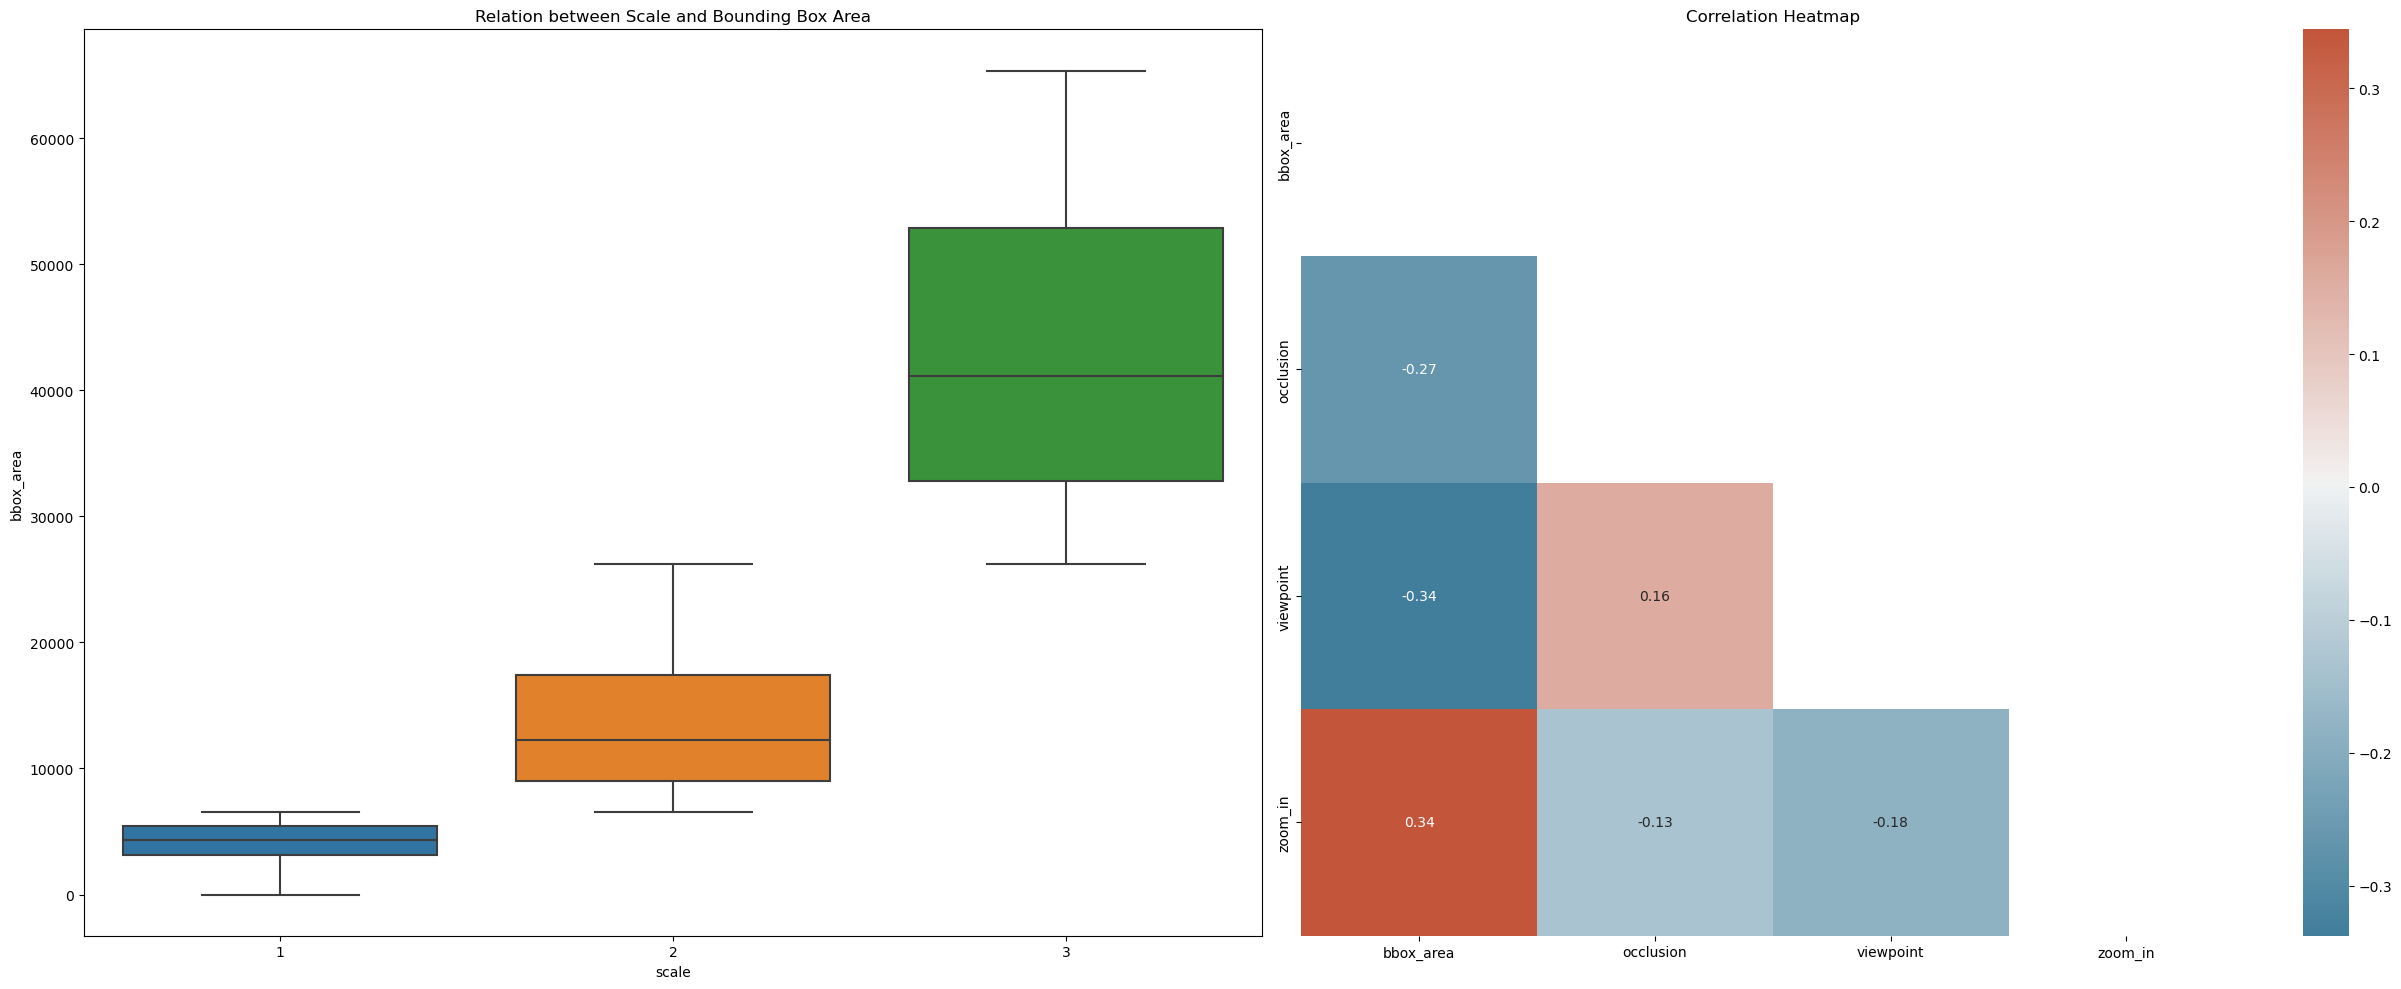

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(25,10))
sns.boxplot(x='scale', y='bbox_area', ax=ax[0], data=train_df_resized).set_title('Relation between Scale and Bounding Box Area')

correlation_matrix = train_df_resized[['bbox_area', 'occlusion', 'viewpoint', 'zoom_in']].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap=sns.diverging_palette(230, 20, as_cmap=True), ax=ax[1]).set_title('Correlation Heatmap')

plt.tight_layout()
plt.show()

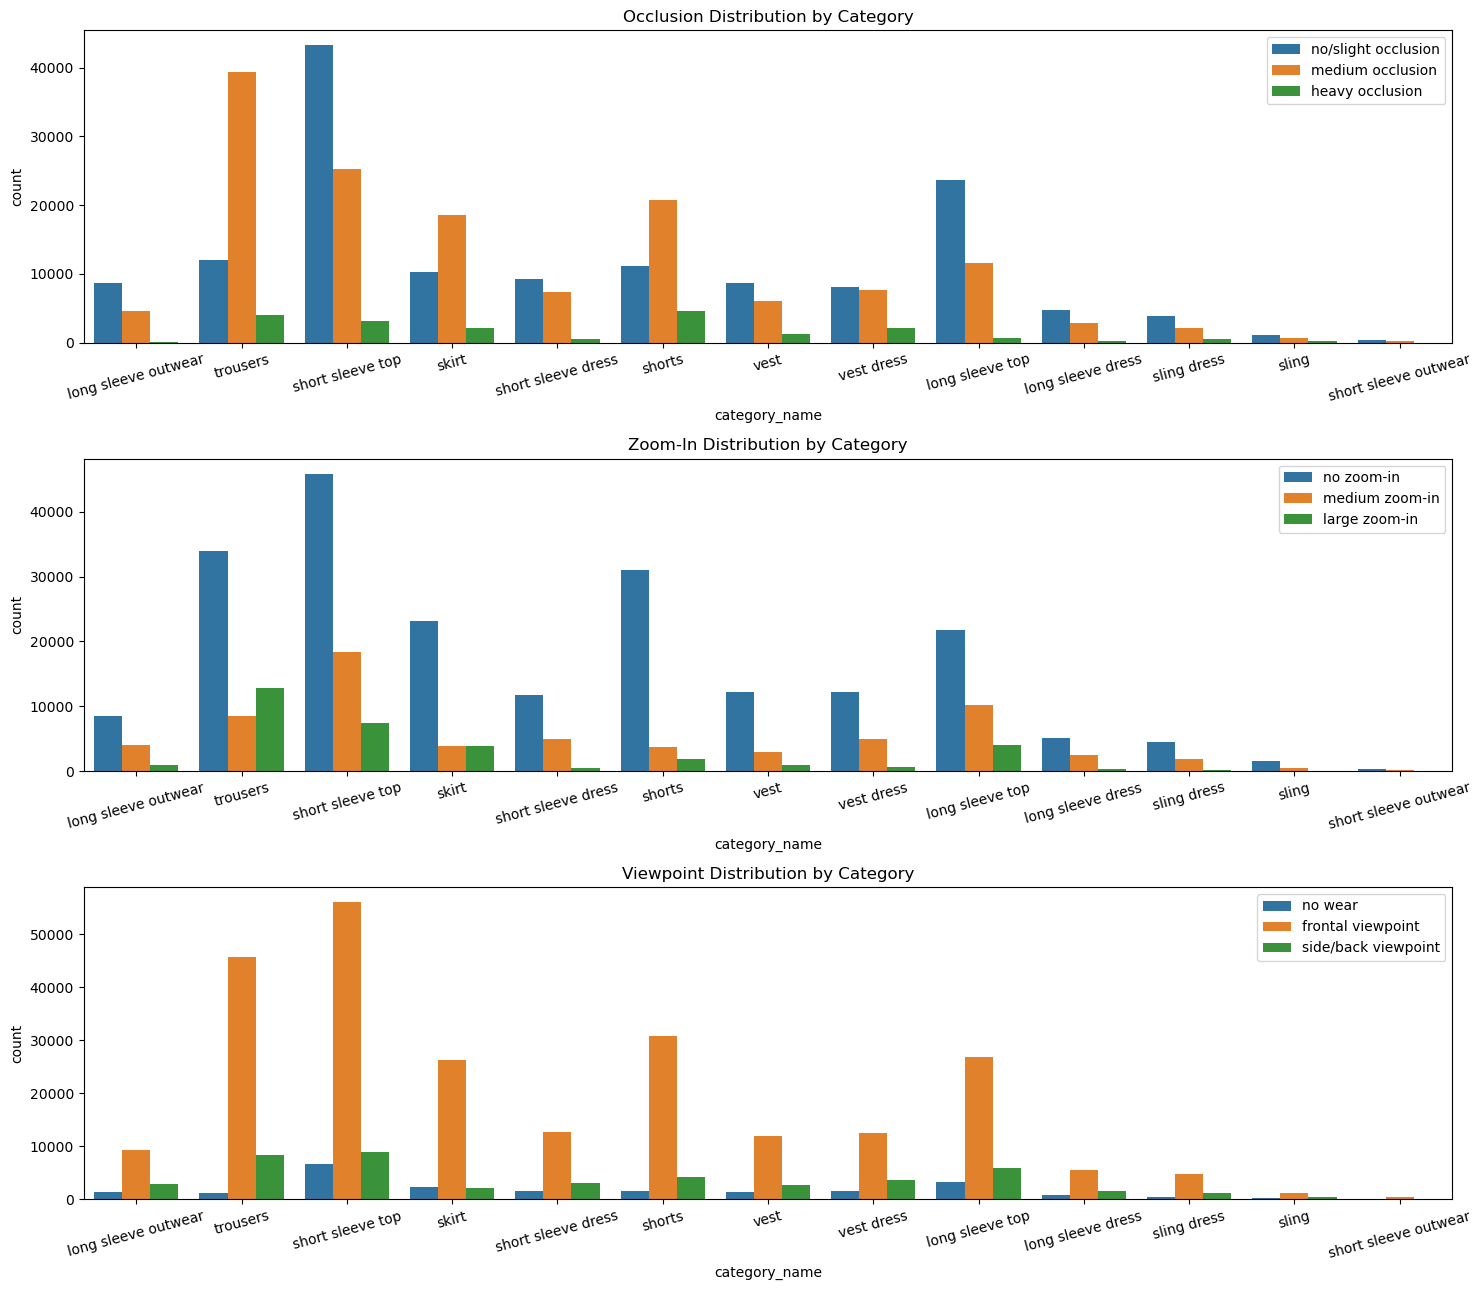

In [31]:
fig, axes = plt.subplots(3, 1, figsize=(15,13))

sns.countplot(data=train_df_resized, x='category_name', hue='occlusion', ax=axes[0]).set_title('Occlusion Distribution by Category')
axes[0].legend(['no/slight occlusion', 'medium occlusion', 'heavy occlusion'])
axes[0].tick_params('x', labelrotation=15)

sns.countplot(data=train_df_resized, x='category_name', hue='viewpoint', ax=axes[2]).set_title('Viewpoint Distribution by Category')
axes[2].legend(['no wear', 'frontal viewpoint', 'side/back viewpoint'])
axes[2].tick_params('x', labelrotation=15)

sns.countplot(data=train_df_resized, x='category_name', hue='zoom_in', ax=axes[1]).set_title('Zoom-In Distribution by Category')
axes[1].legend(['no zoom-in', 'medium zoom-in', 'large zoom-in'])
axes[1].tick_params('x', labelrotation=15)

plt.tight_layout()
plt.show()

In [35]:
def plot_image_with_bbox(image_path, bbox, category, ax):
    """
    Display an image with its bounding box.
    
    Parameters:
    - image_path: Path to the image file.
    - bbox: A list [x1, y1, x2, y2] representing the bounding box.
    - category: Name of the clothing category.
    - ax: Axis on which the image needs to be plotted.
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        
    # Display the image
    ax.imshow(image)

    # Create a Rectangle patch for the bounding box
    x1, y1, x2, y2 = bbox
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
    
    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.text(x1, y1-5, category, bbox=dict(facecolor='red', alpha=0.5), color='white', fontsize=10)

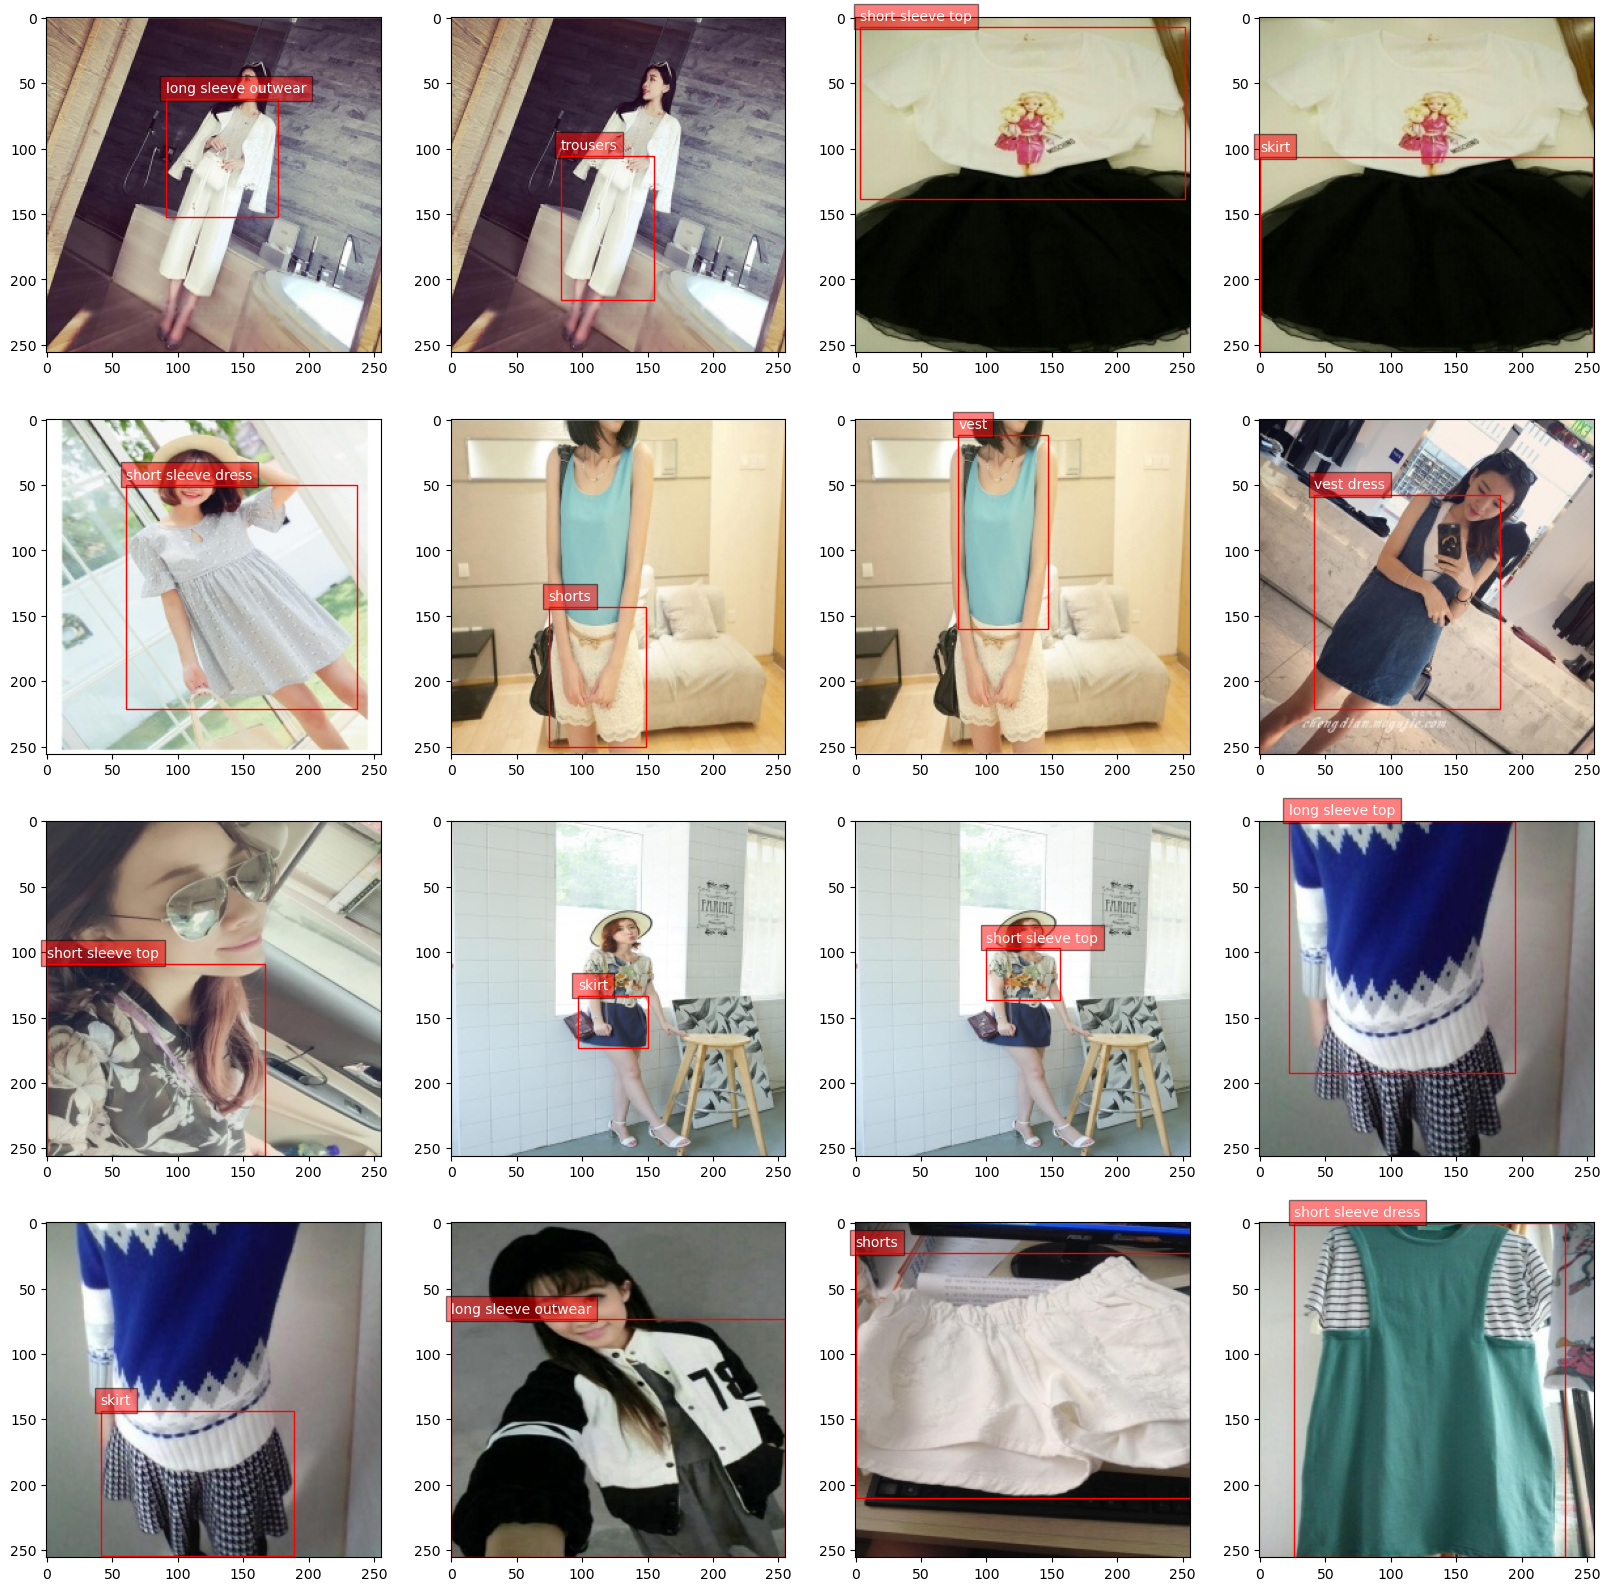

In [37]:
plt.figure(figsize=(20, 20))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    img_path = train_df_resized.path[i]
    b_box = train_df_resized.b_box[i]
    category = train_df_resized.category_name[i]
    plot_image_with_bbox(img_path, b_box, category, ax)
    
plt.show()

In [38]:
def plot_image_with_masks(img_path, segmentations, category, ax):
    image = Image.open(img_path)
    draw = ImageDraw.Draw(image)
    for seg in segmentations:
        x = seg[::2]
        y = seg[1::2]
        xy = [(xi, yi) for xi, yi in zip(x, y)]
        poly = Image.new('RGBA', image.size)
        pdraw = ImageDraw.Draw(poly)
        pdraw.polygon(xy, fill=(255,0,255,128),outline=(0,0,0,255))
        image.paste(poly, mask=poly)

        ax.imshow(image)
        ax.axis('off')
        ax.set_title(category)

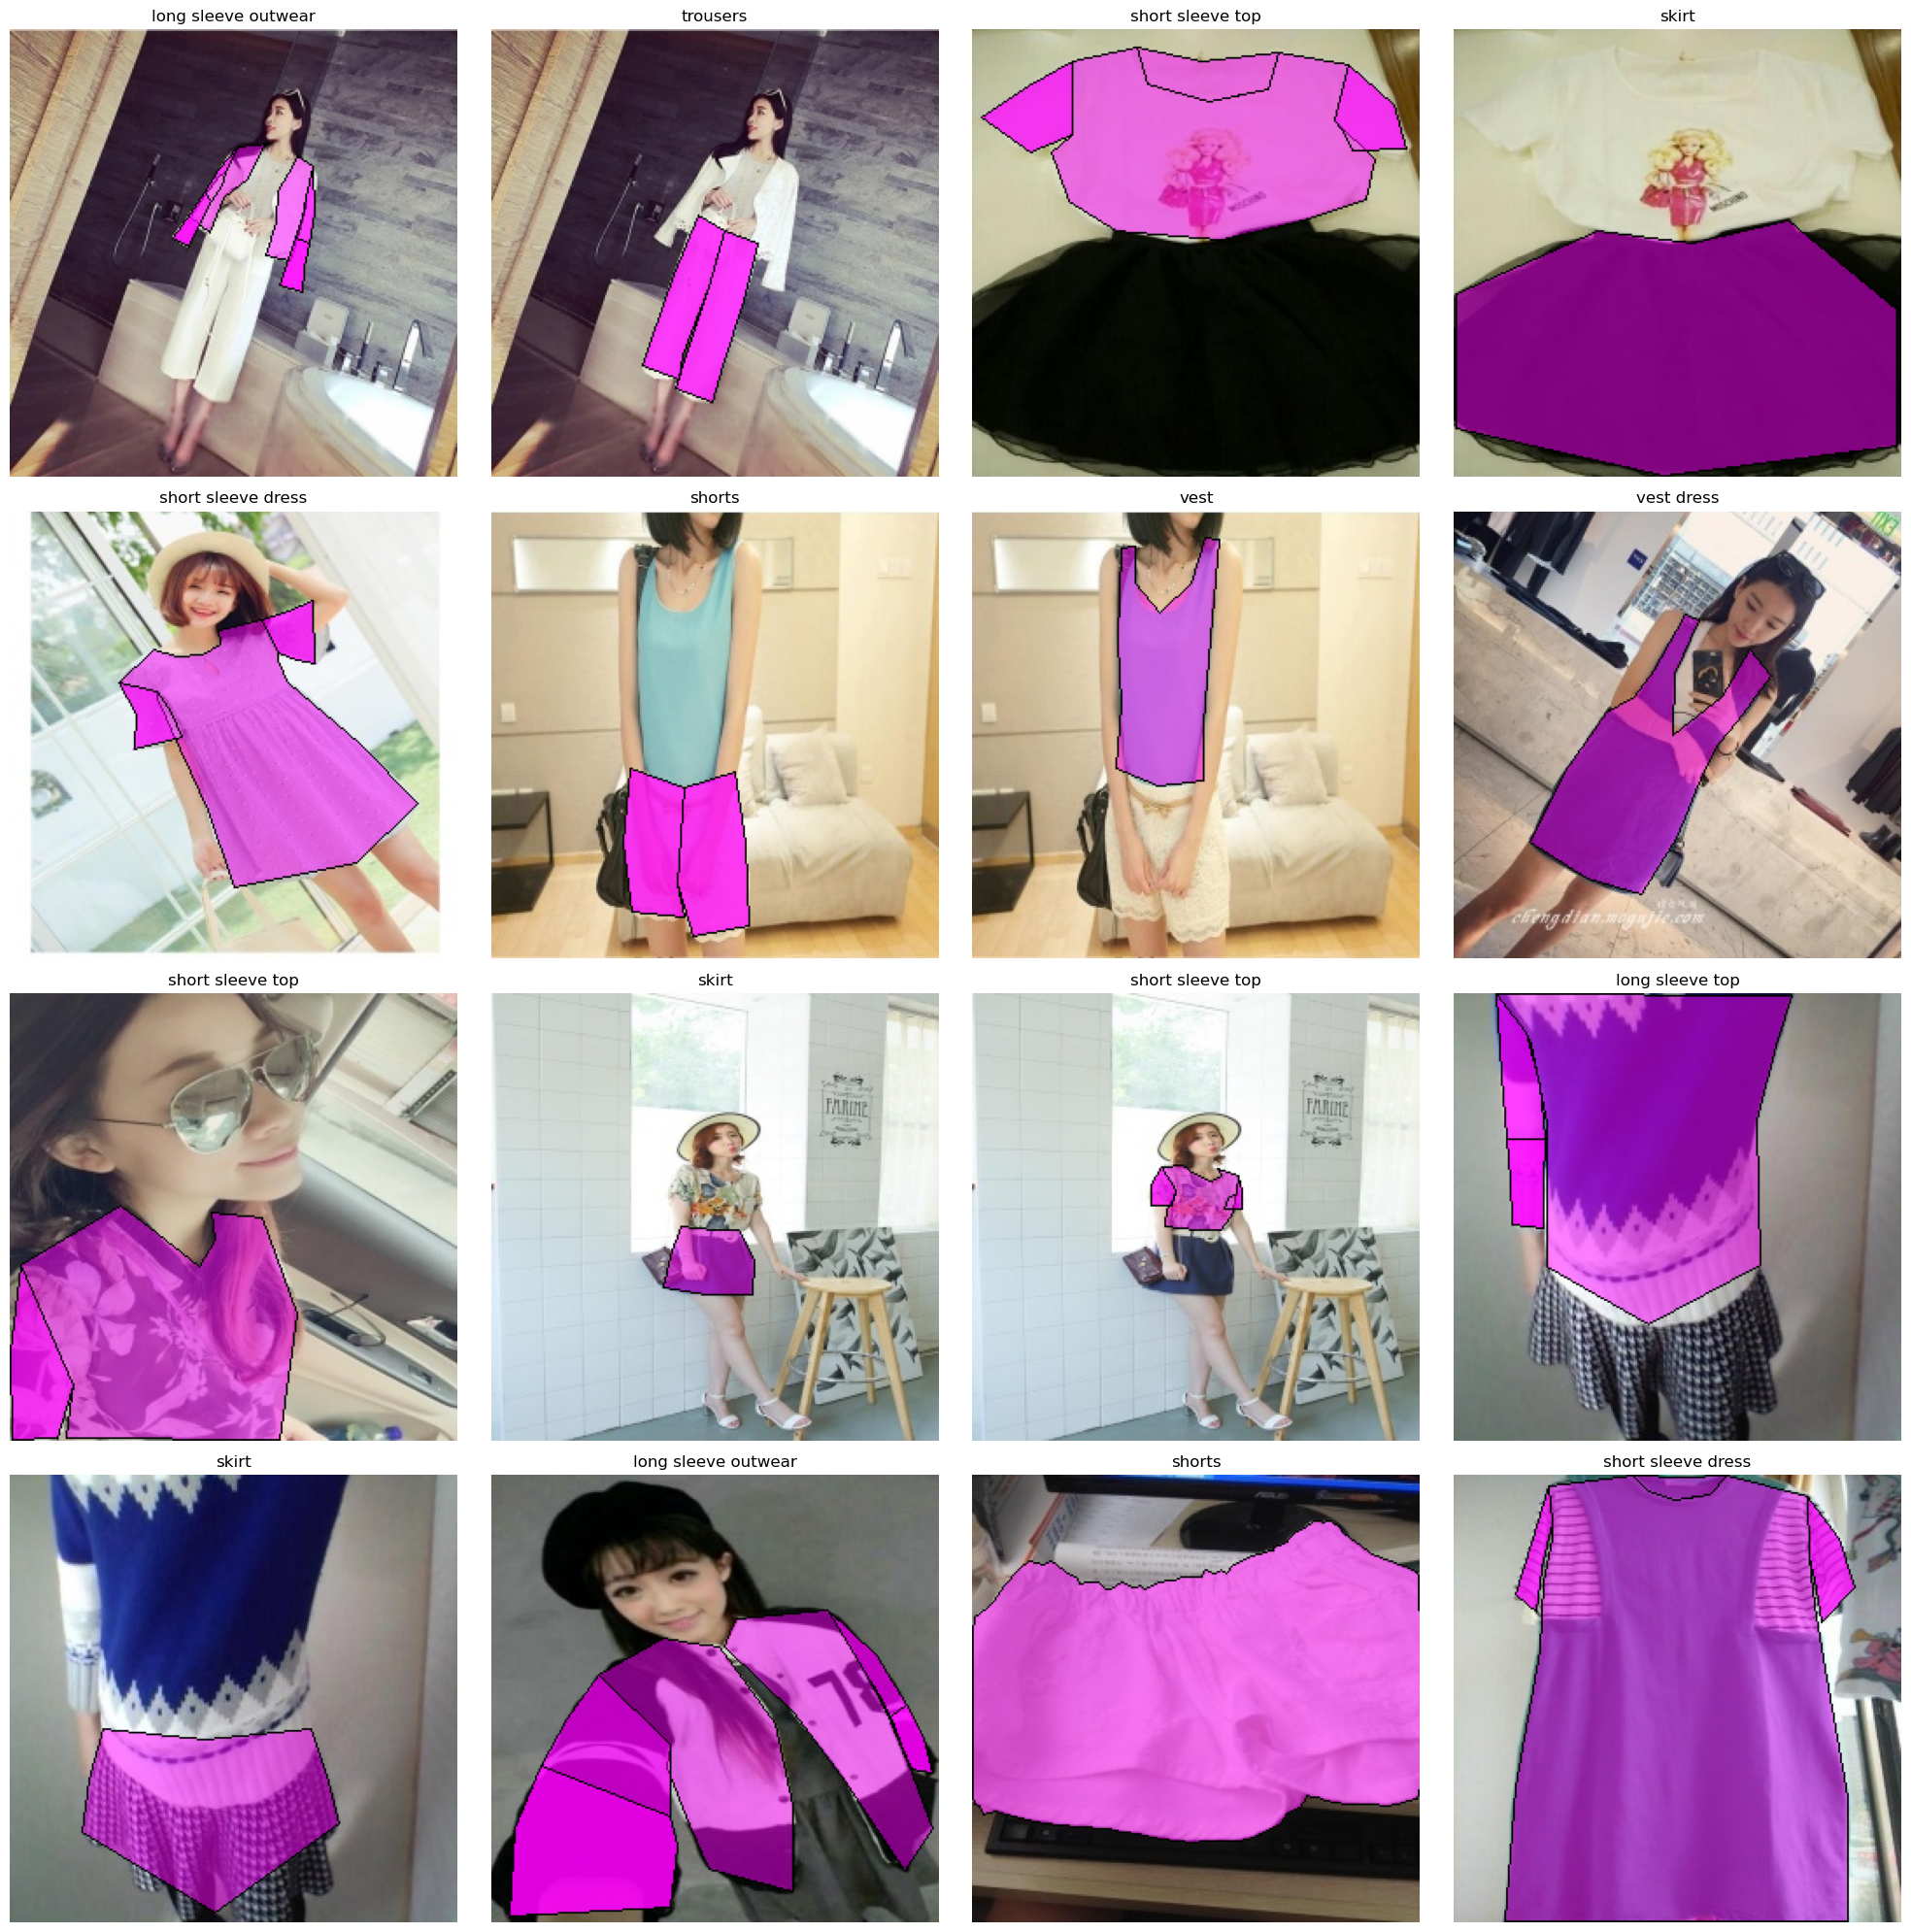

In [40]:
plt.figure(figsize=(20, 20))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    img_path = train_df_resized.path[i]
    segmentations = train_df_resized.segmentation[i]
    category = train_df_resized.category_name[i]
    plot_image_with_masks(img_path, segmentations, category, ax)

plt.tight_layout()
plt.show()

In [ ]:
# # # Clearing up disk space

# # To remove empty/non-empty folders
shutil.rmtree("/kaggle/working/resized")
shutil.rmtree("/kaggle/working/input")

# # To remove files
os.remove("/kaggle/working/resized_dataframes.zip")